https://towardsdatascience.com/modeling-customer-churn-for-an-e-commerce-business-with-python-874315e688bf

El dataset tiene las transacciones de usuarios que realizaron en una determinada tienda 
de Uruguay. El dataset tiene el numero de la factura, el id del usuario, la fecha, el valor del producto
y el id del producto. Una misma factura puede tener mas de un producto

# Libraries

In [1]:
#install.packages('hexbin')

In [2]:
library(tidyverse)
library(lubridate)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




# Load Raw Dataset
EL dataset tiene las columnas:
* Factura
* Fecha
* Customer_ID
* Sexo
* Venta ($)
* Ciudad
* Product ID

In [3]:
col_types <- cols(
    Factura = col_character(),
    Fecha = col_character(),
    Customer_ID = col_character(),
    Sexo = col_character(),
    `Venta ($)` = col_character(),
    Ciudad = col_character(),
    `Product ID` = col_integer()
)
df <- readr::read_delim('../data/Final Project Dataset.csv', ',', col_types = col_types)

# Parse correct data types

In [4]:
df$Fecha <- parse_date(df$Fecha, "%d/%m/%Y")
df <- rename(df, Precio_Venta = 'Venta ($)')
df <- rename(df, Product_ID = 'Product ID')
df$Precio_Venta_2 <- parse_number(df$Precio_Venta, locale = locale(decimal_mark = ",", grouping_mark = "."), na = c("", "NA", "--"))


Warning message:
“2626 parsing failures.
row col expected actual
258  -- a number      -
275  -- a number      -
293  -- a number      -
481  -- a number      -
557  -- a number      -
... ... ........ ......
See problems(...) for more details.
”


In [5]:
head(df)

Factura,Fecha,Customer_ID,Sexo,Precio_Venta,Ciudad,Product_ID,Precio_Venta_2
<chr>,<date>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
227837,2019-08-23,175335,#ERROR!,2.901,Rivera,4,2901
227832,2019-08-23,140862,#ERROR!,7.256,Montevideo Periferia,19,7256
227831,2019-08-23,225831,#ERROR!,2.901,Durazno,4,2901
227826,2019-08-23,185845,#ERROR!,4.462,Montevideo Periferia,0,4462
227823,2019-08-23,153566,#ERROR!,2.901,Rivera,4,2901
227821,2019-08-23,164715,#ERROR!,2.214,Paysandú,3,2214


# Cleanning and transformation

## missing values

In [6]:
cheack_missing <- function(df){
    t(data.frame(n_missing = sapply(df, function(x) sum(is.na(x))),
                 perc_missing = sapply(df, function(x) as.integer(mean(is.na(x))*100))))
}
cheack_missing(df)                                                             

,Factura,Fecha,Customer_ID,Sexo,Precio_Venta,Ciudad,Product_ID,Precio_Venta_2
n_missing,9377,0,1,0,0,0,0,2626
perc_missing,14,0,0,0,0,0,0,4


## Facturas son valor?
Posible estrategia seria llenar con un numero random todas las compras de un usuario en el mismo dia


In [9]:
df <- df %>% 
    mutate(Transaccion_ID = group_indices(., Fecha, Customer_ID))


In [10]:
head(df)

Factura,Fecha,Customer_ID,Sexo,Precio_Venta,Ciudad,Product_ID,Precio_Venta_2,Transaccion_ID
<chr>,<date>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>
227837,2019-08-23,175335,#ERROR!,2.901,Rivera,4,2901,48097
227832,2019-08-23,140862,#ERROR!,7.256,Montevideo Periferia,19,7256,48013
227831,2019-08-23,225831,#ERROR!,2.901,Durazno,4,2901,48151
227826,2019-08-23,185845,#ERROR!,4.462,Montevideo Periferia,0,4462,48119
227823,2019-08-23,153566,#ERROR!,2.901,Rivera,4,2901,48028
227821,2019-08-23,164715,#ERROR!,2.214,Paysandú,3,2214,48064


## Filtrado de las transacciones validas 

In [19]:
df_clean <- df %>% 
    filter(!is.na(Precio_Venta_2),
           !is.na(Customer_ID))

In [21]:
cheack_missing(df_clean)

,Factura,Fecha,Customer_ID,Sexo,Precio_Venta,Ciudad,Product_ID,Precio_Venta_2,Transaccion_ID
n_missing,8309,0,0,0,0,0,0,0,0
perc_missing,13,0,0,0,0,0,0,0,0


In [20]:
summary(df_clean)

   Factura              Fecha            Customer_ID            Sexo          
 Length:62381       Min.   :2018-01-02   Length:62381       Length:62381      
 Class :character   1st Qu.:2018-07-13   Class :character   Class :character  
 Mode  :character   Median :2018-12-19   Mode  :character   Mode  :character  
                    Mean   :2018-12-09                                        
                    3rd Qu.:2019-05-10                                        
                    Max.   :2019-08-31                                        
 Precio_Venta          Ciudad            Product_ID     Precio_Venta_2 
 Length:62381       Length:62381       Min.   : 0.000   Min.   :  403  
 Class :character   Class :character   1st Qu.: 1.000   1st Qu.: 2901  
 Mode  :character   Mode  :character   Median : 5.000   Median : 4538  
                                       Mean   : 6.851   Mean   : 4719  
                                       3rd Qu.: 9.000   3rd Qu.: 6046  
               

## Feature engineering

### Detalle de la compra

In [22]:
resumen_compra <- df_clean %>% 
    group_by(Transaccion_ID) %>% 
    summarise(n_prod = n(),
              total_venta = sum(Precio_Venta_2),
             ) %>% 
    ungroup()

resumen_compra[sample(nrow(resumen_compra), 10),]

`summarise()` ungrouping output (override with `.groups` argument)



Transaccion_ID,n_prod,total_venta
<int>,<int>,<dbl>
13592,1,706
43350,1,5240
8578,5,18633
31955,1,6168
39560,1,6046
46285,1,5079
20318,1,4558
21902,3,5082
12400,1,7983


### Detalles de la transacción

In [26]:
transaccion <- df_clean %>% 
    distinct(Transaccion_ID, Fecha, Customer_ID, Ciudad) %>% 
    mutate(Dias_Ultima_Compra = as.integer(max(Fecha) - Fecha))

head(feactura)

Fecha,Customer_ID,Ciudad,Transaccion_ID,Dias_Ultima_Compra
<date>,<chr>,<chr>,<int>,<int>
2019-08-23,175335,Rivera,48097,8
2019-08-23,140862,Montevideo Periferia,48013,8
2019-08-23,225831,Durazno,48151,8
2019-08-23,185845,Montevideo Periferia,48119,8
2019-08-23,153566,Rivera,48028,8
2019-08-23,164715,Paysandú,48064,8


### Detalles del customer

`summarise()` ungrouping output (override with `.groups` argument)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



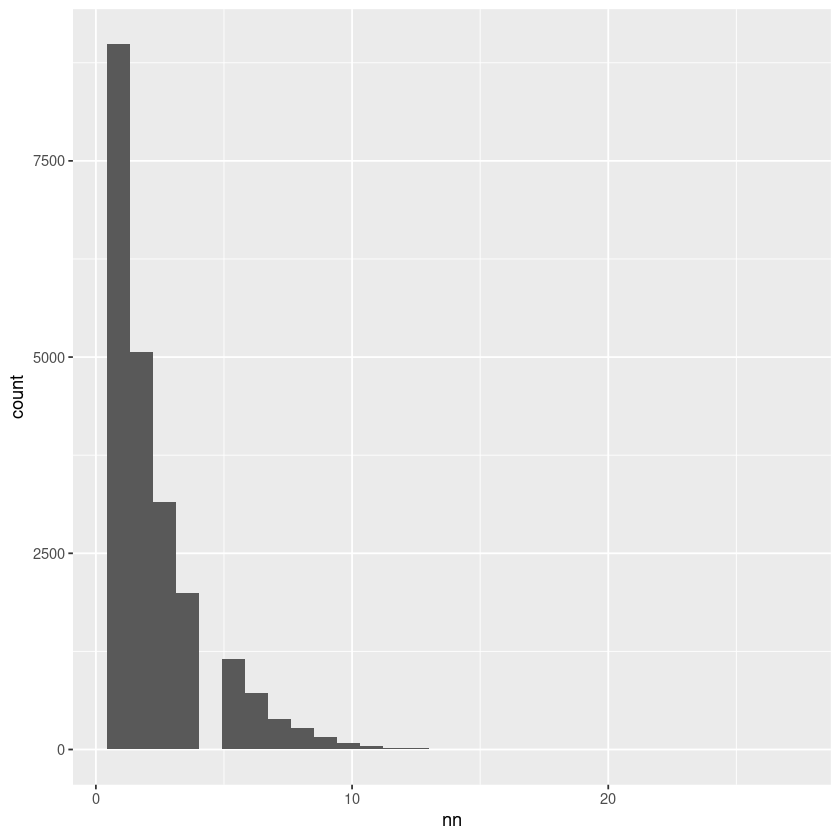

In [24]:
# Diversidad de compra
df_clean %>% 
    group_by(Customer_ID) %>%
    summarise(nn = n_distinct(Product_ID)) %>%
    arrange(nn) %>% 
    ggplot(aes(nn)) + geom_histogram()

In [28]:
resumen_transaccion <- transaccion %>% inner_join(resumen_compra, by = "Transaccion_ID")
head(resumen_transaccion)

Fecha,Customer_ID,Ciudad,Transaccion_ID,Dias_Ultima_Compra,n_prod,total_venta
<date>,<chr>,<chr>,<int>,<int>,<int>,<dbl>
2019-08-23,175335,Rivera,48097,8,1,2901
2019-08-23,140862,Montevideo Periferia,48013,8,1,7256
2019-08-23,225831,Durazno,48151,8,1,2901
2019-08-23,185845,Montevideo Periferia,48119,8,1,4462
2019-08-23,153566,Rivera,48028,8,1,2901
2019-08-23,164715,Paysandú,48064,8,1,2214


In [31]:
customer  <- resumen_transaccion %>% 
    group_by(Customer_ID) %>% 
    summarise(n_compras = n(),  # frecuencia
              n_productos = sum(n_prod),
              ultimo_dia = min(Dias_Ultima_Compra),
              edad_dias = as.integer(max(Fecha)-min(Fecha))
             ) %>% 
    arrange(n_compras)
head(customer)

`summarise()` ungrouping output (override with `.groups` argument)



Customer_ID,n_compras,n_productos,ultimo_dia,edad_dias
<chr>,<int>,<int>,<int>,<int>
06444-,1,1,38,0
100032,1,1,49,0
100046,1,1,549,0
100058,1,1,158,0
100081,1,1,446,0
100114,1,1,53,0


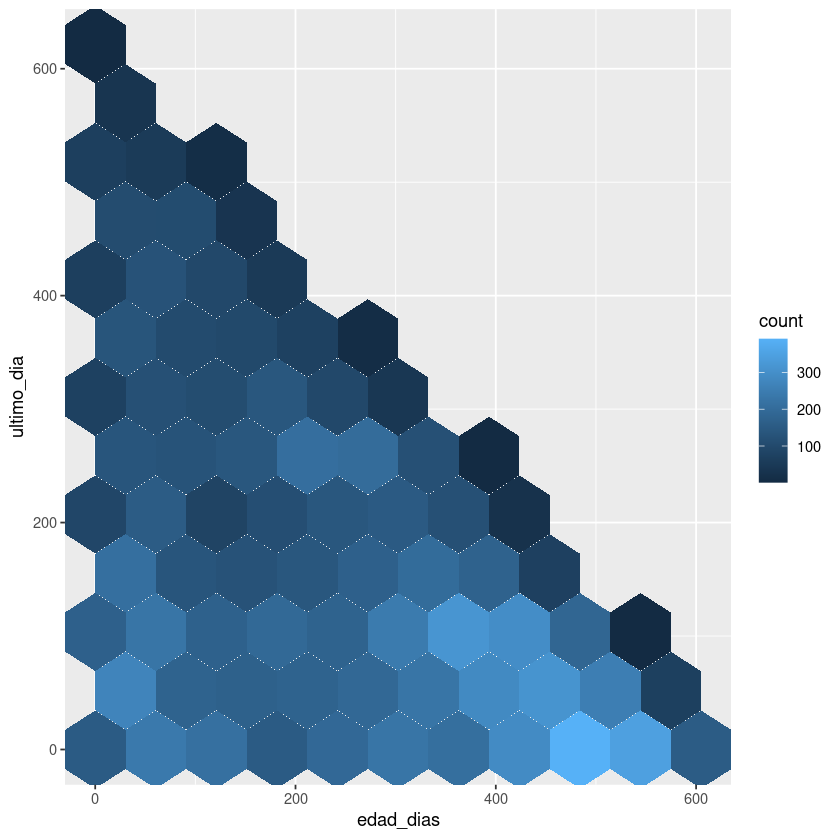

In [43]:
customer %>% 
    filter(edad_dias > 0) %>% 
    ggplot(aes(x=edad_dias, y=ultimo_dia)) + geom_hex(bins = 10)

In [45]:
customer %>% 
    filter(edad_dias > 0) %>% 
    mutate(thr = ultimo_dia>250) %>% 
    summarise(thr_mean = mean(thr))


thr_mean
<dbl>
0.2026138


In [171]:
customer %>% mutate(x = ultimo_dia > 400) %>% select(x) %>% summarise(x_mean=mean(x))

x_mean
<dbl>
0.1655687


Warning message:
“Removed 3 rows containing missing values (geom_point).”


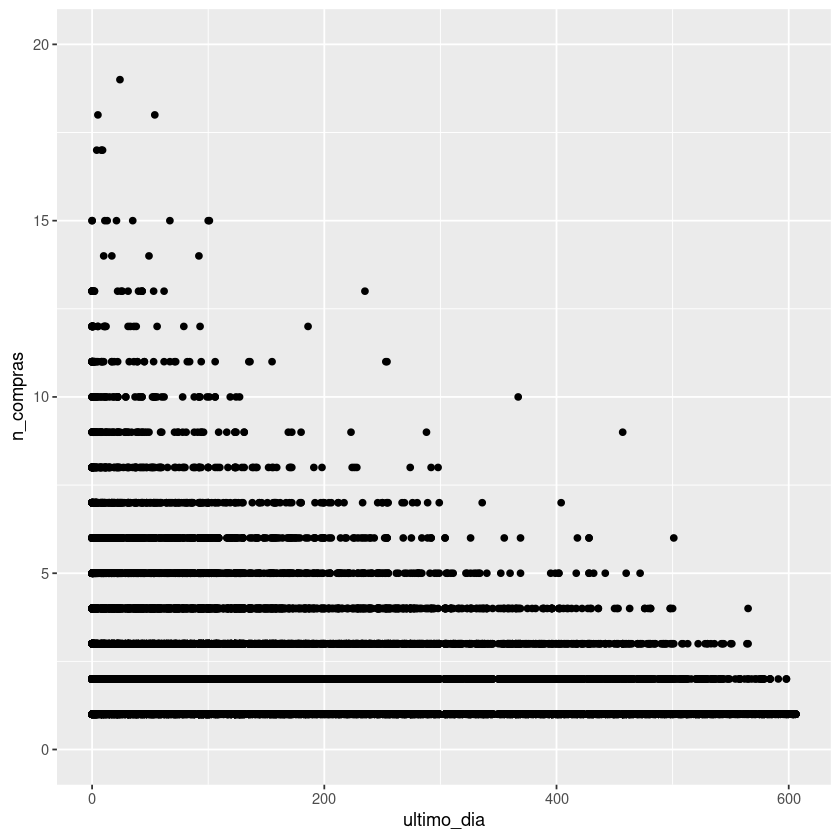

In [46]:
customer %>% ggplot(aes(x=ultimo_dia, y=n_compras)) + geom_point()+ ylim(0, 20)

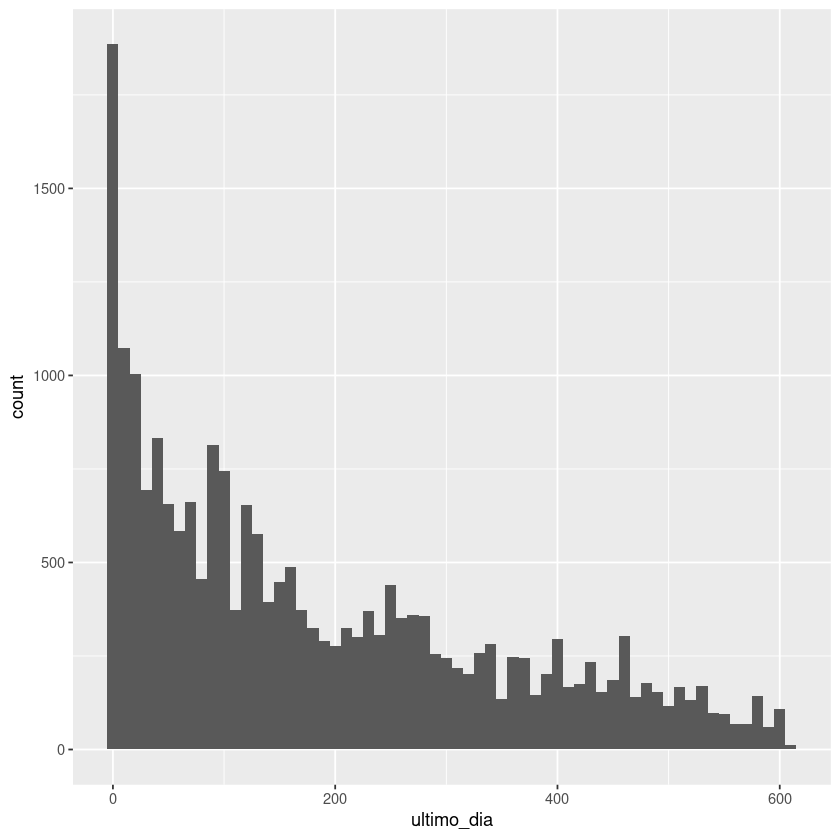

In [47]:
customer %>% ggplot(aes(x=ultimo_dia)) + geom_histogram(binwidth = 10)

In [92]:
df_clean %>% count(Product_ID)

Product_ID,n
<int>,<int>
0,9294
1,6443
2,6631
3,3786
4,4898
5,3883
6,4495
7,3625
8,2907
